# Data Preparation

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from nltk.stem.snowball import FrenchStemmer

## Data Cleaning

### Downloading data

In [ ]:
# Load the datasets
interactions = pd.read_csv('https://raw.githubusercontent.com/olivialaven/MGT502_project/refs/heads/main/interactions_train.csv')
items = pd.read_csv("https://raw.githubusercontent.com/olivialaven/MGT502_project/refs/heads/main/merged_items_updated.csv")


In [3]:
book_embeddings_openai = np.load('/Users/danieldieckmann/Documents/University/EPFL/SMT/SMT MA2/Machine Learning/Code project/book_embeddings_openai.npy')

In [4]:
n_users = interactions.u.nunique()
n_items = items.i.nunique() # CHECK
print(f'Number of users = {n_users}, \nNumber of books (in total, incl. unread books) = {n_items} \nNumber of interactions = {len(interactions)}')

Number of users = 7838, 
Number of books (in total, incl. unread books) = 15291 
Number of interactions = 87047


### Removing duplicates

In [5]:
# Checking duplicates in the interactions and items datasets
interaction_duplicates = interactions.duplicated().sum()
items_duplicates = items.duplicated().sum()
print(f'Interaction data duplicates = {interaction_duplicates}, Item data duplicates = {items_duplicates}')

Interaction data duplicates = 2, Item data duplicates = 0


In [6]:
# Showing the duplicated rows
duplicate_rows = interactions[interactions.duplicated(keep=False)]  # keep=False to show all duplicates
print(f"Duplicate rows in interaction data:\n{duplicate_rows}")

Duplicate rows in interaction data:
          u      i             t
4156   7210  12290  1.718023e+09
6103   7210  12290  1.718023e+09
34656  1323  10037  1.700055e+09
44025  1323  10037  1.700055e+09


In [7]:
interactions_original = interactions.copy()

In [8]:
interactions.drop_duplicates(keep='first', inplace=True)

In [9]:
# Checking duplicates in the interactions and items datasets
interaction_duplicates = interactions.duplicated().sum()
items_duplicates = items.duplicated().sum()
print(f'Interaction data duplicates = {interaction_duplicates}, Item data duplicates = {items_duplicates}')

Interaction data duplicates = 0, Item data duplicates = 0


In [10]:
# Getting the unique values for each column

# For interactions DataFrame
unique_counts_interactions = {column: interactions[column].nunique() for column in interactions.columns}
unique_counts_interactions_df = pd.DataFrame(unique_counts_interactions, index=['Unique Values']).T
print("Unique Value Counts for interactions DataFrame:")
display(unique_counts_interactions_df)

# For items DataFrame
unique_counts_items = {column: items[column].nunique() for column in items.columns}
unique_counts_items_df = pd.DataFrame(unique_counts_items, index=['Unique Values']).T
print("\nUnique Value Counts for items DataFrame:")
display(unique_counts_items_df)

Unique Value Counts for interactions DataFrame:


,Unique Values
u,7838
i,15109
t,86768



Unique Value Counts for items DataFrame:


,Unique Values
Title,14572
Author,10712
ISBN Valid,14490
Publisher,4337
Subjects,11478
i,15291
description,2591
mainCategory,905
publisher,1821
synopsis,7362


In [11]:
# For interactions DataFrame
missing_interactions = interactions.isnull().sum()
missing_interactions_df = pd.DataFrame(missing_interactions, columns=['Missing Values']).T # Transpose for better display

# For items DataFrame
missing_items = items.isnull().sum()
missing_items_df = pd.DataFrame(missing_items, columns=['Missing Values']).T # Transpose for better display

# Display the DataFrames
print("Missing Values in interactions DataFrame:")
display(missing_interactions_df)

print("\nMissing Values in items DataFrame:")
display(missing_items_df)

Missing Values in interactions DataFrame:


,u,i,t
Missing Values,0,0,0



Missing Values in items DataFrame:


,Title,Author,ISBN Valid,Publisher,Subjects,i,description,mainCategory,publisher,synopsis,...,date_published,subjects,isbn13,msrp,binding,isbn,isbn10,edition,related,dewey_decimal
Missing Values,0,1202,723,25,2223,0,12688,13557,4223,7797,...,4366,6239,3997,3997,4191,3997,4612,13052,14926,14884


In [12]:
items[items['Author'].isnull() & items['Subjects'].isnull() & items['ISBN Valid'].isnull() & items['Publisher'].isnull()]

,Title,Author,ISBN Valid,Publisher,Subjects,i,description,mainCategory,publisher,synopsis,...,date_published,subjects,isbn13,msrp,binding,isbn,isbn10,edition,related,dewey_decimal
1345,YYYY Prêt interbibliothèques BPUL,NaN,NaN,NaN,NaN,1345,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9460,"4bis-113: Périodique (prêt 28 jours), numéro n...",NaN,NaN,NaN,NaN,9460,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11744,Lectures Courantes Extraites des Écrivains Fra...,NaN,NaN,NaN,NaN,11744,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14378,Clé USB 8Go,NaN,NaN,NaN,NaN,14378,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Test train split

In [13]:
interactions = interactions.sort_values(["u", "t"])

interactions["pct_rank"] = interactions.groupby("u")["t"].rank(pct=True, method='dense')
interactions.reset_index(inplace=True, drop=True)
interactions.head(10)

train_data = interactions[interactions["pct_rank"] < 0.8]
test_data = interactions[interactions["pct_rank"] >= 0.8]

In [14]:
def create_data_matrix(data, n_users, n_items):
    data_matrix = np.zeros((n_users, n_items))
    data_matrix[data["u"].values, data["i"].values] = 1
    return data_matrix

# Data Exploration

## Most frequent authors, publisher, subjects, and main category

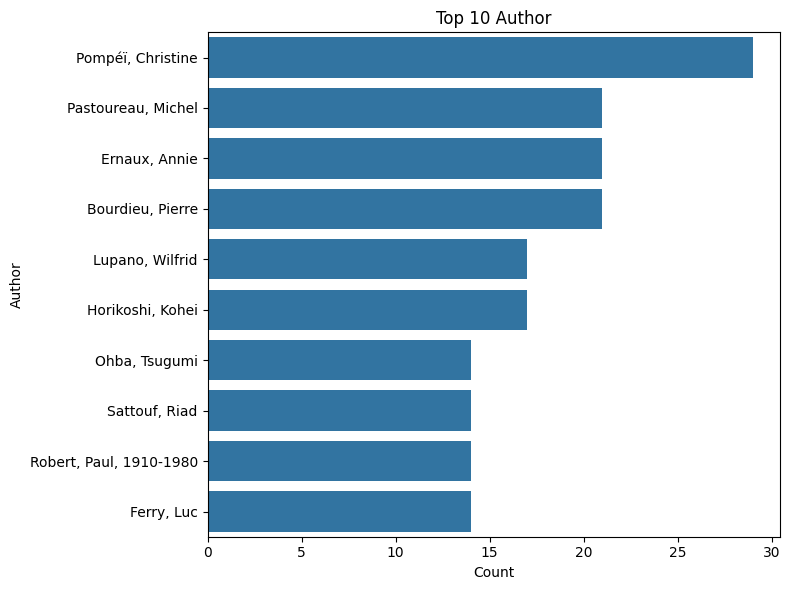

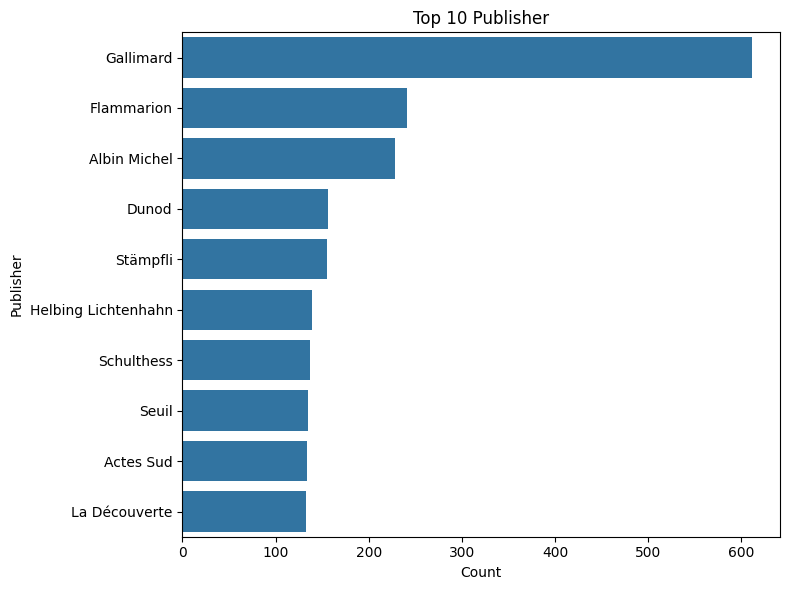

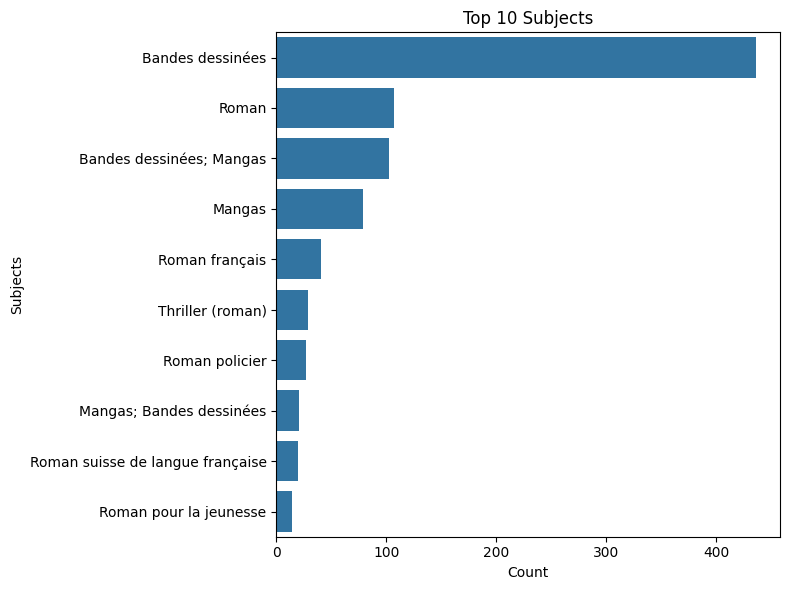

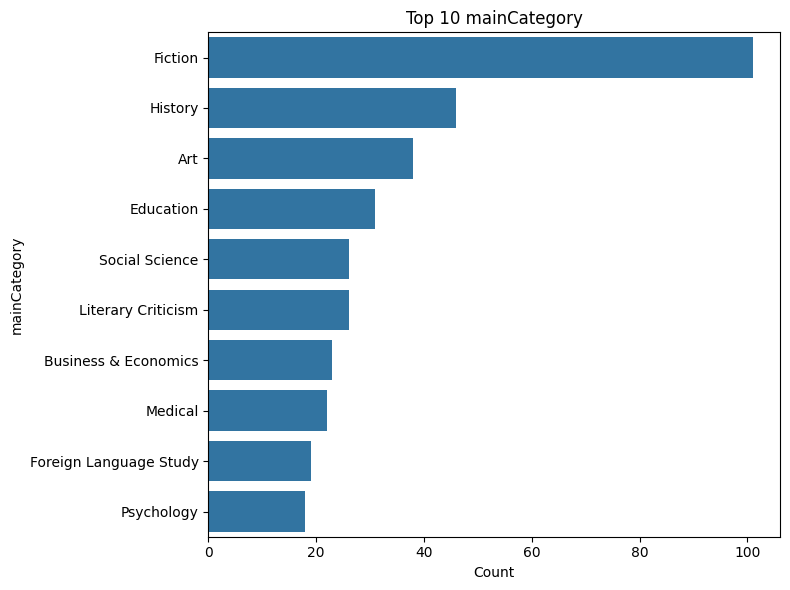

In [15]:
# List of columns to visualize the top 10 for
columns_to_visualize = ['Author', 'Publisher', 'Subjects','mainCategory']

for col in columns_to_visualize:
    if col in items.columns:
        # Get the value counts for the column
        top_values = items[col].value_counts().head(10)

        # Create a figure and axes for the plot
        plt.figure(figsize=(8, 6))

        # Create a bar plot
        sns.barplot(x=top_values.values, y=top_values.index)

        plt.title(f'Top 10 {col}')
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Column '{col}' not found in merged_items.")

## Frequency relating to interactions

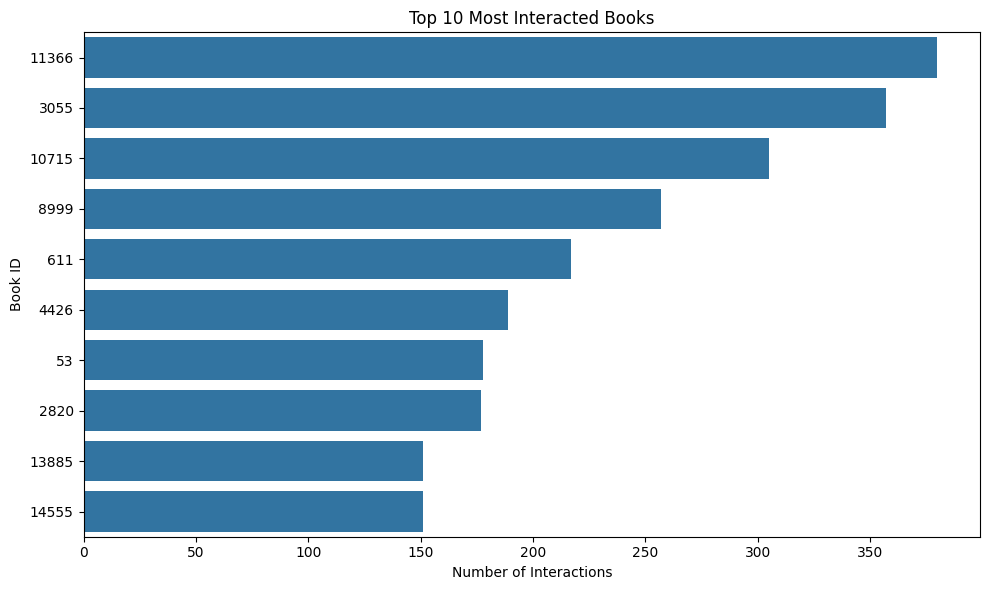

In [16]:
# Get the top 10 interacted books
top_books = interactions['i'].value_counts().head(10).index

# Filter the items DataFrame to get information about the top books
top_books_info = items[items['i'].isin(top_books)]

# Create the countplot
plt.figure(figsize=(10, 6))
sns.countplot(data=interactions,
              y='i',
              order=top_books)
plt.title('Top 10 Most Interacted Books')
plt.ylabel('Book ID')
plt.xlabel('Number of Interactions')
plt.tight_layout()
plt.show()

## Number of interactions per user

In [17]:
# Group by user and count the number of interactions
user_interactions_count = interactions.groupby('u')['i'].count().reset_index()

# Rename the count column for clarity
user_interactions_count.rename(columns={'i': 'interaction_count'}, inplace=True)

# Group by interaction count and get the size of each group
interaction_counts_table = user_interactions_count.groupby('interaction_count').size().reset_index()

# Rename columns for better readability
interaction_counts_table.columns = ['Number of Books Interacted With', 'Number of Users']

# Display the table
print("Number of users who interacted with a specific number of books:")
display(interaction_counts_table)

Number of users who interacted with a specific number of books:


,Number of Books Interacted With,Number of Users
0,3,2445
1,4,752
2,5,540
3,6,480
4,7,685
...,...,...
126,175,1
127,199,1
128,200,1
129,254,1


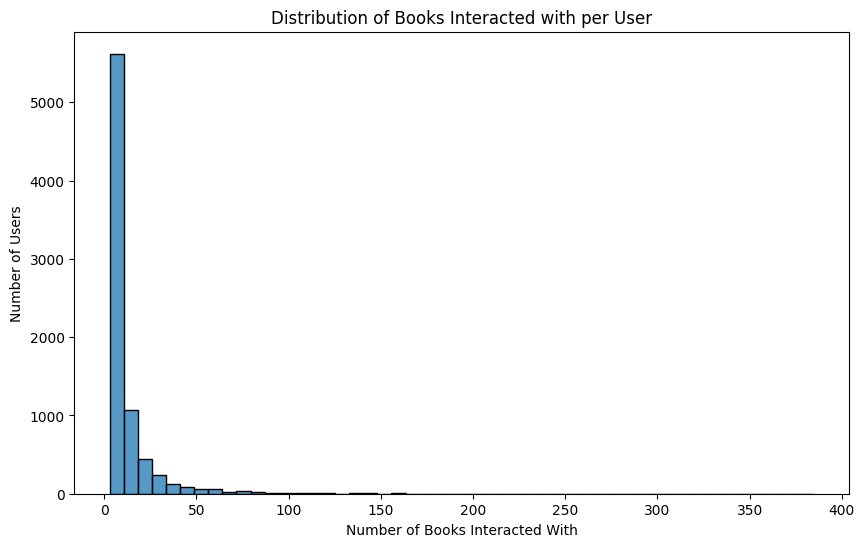

In [18]:
# Plot a histogram showing the distribution of number of interactions per user
plt.figure(figsize=(10, 6))
sns.histplot(user_interactions_count['interaction_count'], bins=50)
plt.title('Distribution of Books Interacted with per User')
plt.xlabel('Number of Books Interacted With')
plt.ylabel('Number of Users')
plt.show()

In [19]:
# Group by user and item, then count the occurrences
interaction_counts = interactions.groupby(['u', 'i']).size().reset_index(name='interaction_count')

# Filter for interactions that happened more than once
multiple_interactions = interaction_counts[interaction_counts['interaction_count'] > 1]

# Count how many users interacted with an item a specific number of times
users_with_multiple_interactions = multiple_interactions.groupby('interaction_count')['u'].nunique().reset_index(name='number_of_users')

# Display the result
print("Number of users who interacted with an item multiple times:")
display(users_with_multiple_interactions)

Number of users who interacted with an item multiple times:


,interaction_count,number_of_users
0,2,2996
1,3,1285
2,4,615
3,5,324
4,6,220
5,7,98
6,8,76
7,9,64
8,10,48
9,11,44


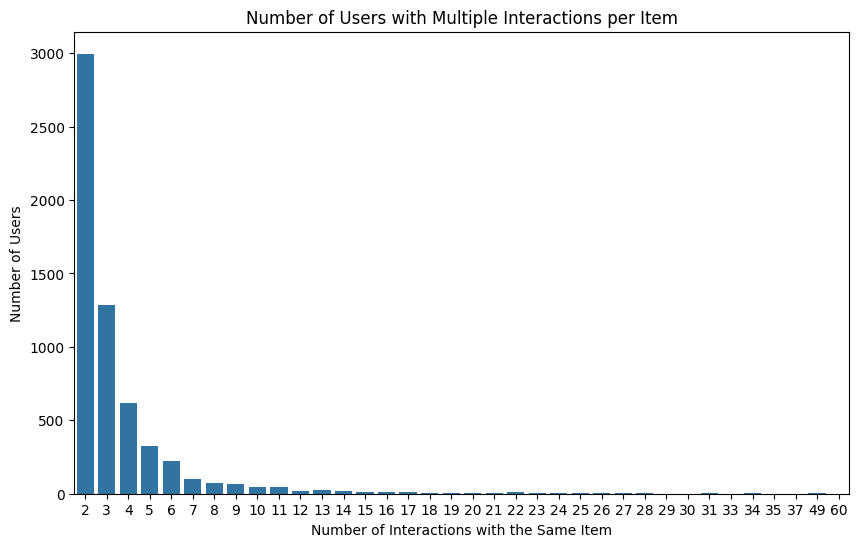

In [20]:
# Create a bar plot of the number of users who interacted with an item multiple times
plt.figure(figsize=(10, 6))
sns.barplot(x='interaction_count', y='number_of_users', data=users_with_multiple_interactions)
plt.title('Number of Users with Multiple Interactions per Item')
plt.xlabel('Number of Interactions with the Same Item')
plt.ylabel('Number of Users')
plt.show()

### Creating differnt folds

In [21]:
import numpy as np
import pandas as pd

def create_kfold_user_splits(interactions, n_splits=3, random_state=42):
    """
    Splits each user's interactions into n_splits folds.
    For each fold, uses 1/n_splits as test and the rest as train.
    Ensures that the test set for each user has at least one observation.
    """
    np.random.seed(random_state)
    users = interactions['u'].unique()
    folds = [[] for _ in range(n_splits)]

    for u in users:
        user_df = interactions[interactions["u"] == u].copy()
        n = len(user_df)
        # Shuffle user interactions
        user_df = user_df.sample(frac=1, random_state=hash(u) % (2**32)).reset_index(drop=True)
        # Compute fold sizes (as even as possible)
        fold_sizes = [n // n_splits] * n_splits
        for i in range(n % n_splits):
            fold_sizes[i] += 1
        # Ensure at least one in each fold (if n < n_splits, some folds will be empty)
        current = 0
        user_folds = []
        for size in fold_sizes:
            user_folds.append(user_df.iloc[current:current + size])
            current += size
        # For each fold, create train/test split
        for i in range(n_splits):
            test = user_folds[i]
            # If test is empty (possible if n < n_splits), sample one for test
            if len(test) == 0:
                test = user_df.sample(n=1, random_state=random_state)
                train = user_df.drop(test.index)
            else:
                train = pd.concat(user_folds[:i] + user_folds[i+1:], ignore_index=True)
            folds[i].append((train, test))

    # Combine all users' splits for each fold
    result = []
    for i in range(n_splits):
        train_parts = [t[0] for t in folds[i]]
        test_parts = [t[1] for t in folds[i]]
        train_df = pd.concat(train_parts).reset_index(drop=True)
        test_df = pd.concat(test_parts).reset_index(drop=True)
        result.append((train_df, test_df))

    return result

# Example usage:
folds = create_kfold_user_splits(interactions, n_splits=3, random_state=42)
(train_1, test_1), (train_2, test_2), (train_3, test_3) = folds

# Recommender Systems

### Evalutation

In [22]:
import numpy as np

# TODO: Implement the precision_recall_at_k function
def precision_recall_at_k(prediction, ground_truth, k=10):
    """
    Calculates Precision@K and Recall@K for top-K recommendations.
    Parameters:
        prediction (numpy array): The predicted interaction matrix with scores.
        ground_truth (numpy array): The ground truth interaction matrix (binary).
        k (int): Number of top recommendations to consider.
    Returns:
        precision_at_k (float): The average precision@K over all users.
        recall_at_k (float): The average recall@K over all users.
    """
    num_users = prediction.shape[0]
    precision_at_k, recall_at_k = 0, 0

    for user in range(num_users):
        # TODO: Get the indices of the top-K items for the user based on predicted scores
        top_k_items = np.argsort(prediction[user, :])[-k:]

        # TODO: Calculate the number of relevant items in the top-K items for the user
        relevant_items_in_top_k = np.isin(top_k_items, np.where(ground_truth[user, :] == 1)[0]).sum()

        # TODO: Calculate the total number of relevant items for the user
        total_relevant_items = ground_truth[user, :].sum()

        # Precision@K and Recall@K for this user
        precision_at_k += relevant_items_in_top_k / k
        recall_at_k += relevant_items_in_top_k / total_relevant_items if total_relevant_items > 0 else 0

    # Average Precision@K and Recall@K over all users
    precision_at_k /= num_users
    recall_at_k /= num_users

    return precision_at_k, recall_at_k


### Test train matrices

In [23]:
def create_data_matrix(data, n_users, n_items):
    data_matrix = np.zeros((n_users, n_items))
    data_matrix[data["u"].values, data["i"].values] = 1
    return data_matrix

In [24]:
# Create the training and testing matrices
train_data_matrix = create_data_matrix(train_data, n_users, n_items)
test_data_matrix = create_data_matrix(test_data, n_users, n_items)
interaction_matrix = create_data_matrix(interactions, n_users, n_items)

## Collaborative Filtering

### Item to item

#### i2i basic

In [25]:
similarity_matrix_items = cosine_similarity(train_data_matrix.T)

def item_based_predict(interactions, similarity, epsilon=1e-9):
    sim_sum = similarity.sum(axis=1, keepdims=True) + epsilon
    pred = interactions.dot(similarity.T) / sim_sum.T
    return pred

# Predict without filtering (use full similarity matrix)
i2i_basic = item_based_predict(train_data_matrix, similarity_matrix_items)

# Evaluate
precision, recall = precision_recall_at_k(i2i_basic, test_data_matrix, k=10)

print(f"Precision@10: {precision:.4f}")
print(f"Recall@10:    {recall:.4f}")

Precision@10: 0.0556
Recall@10:    0.2640


#### Item to item (80/20 split)

In [ ]:
item_similarity = cosine_similarity(train_data_matrix.T)

Grid search over k: 100%|██████████| 6/6 [00:00<00:00, 156.31it/s]


k=10: Precision@10=0.0595, Recall@10=0.2832k=5: Precision@10=0.0588, Recall@10=0.2780

k=25: Precision@10=0.0588, Recall@10=0.2821
k=15: Precision@10=0.0594, Recall@10=0.2837
k=40: Precision@10=0.0580, Recall@10=0.2769k=70: Precision@10=0.0575, Recall@10=0.2743



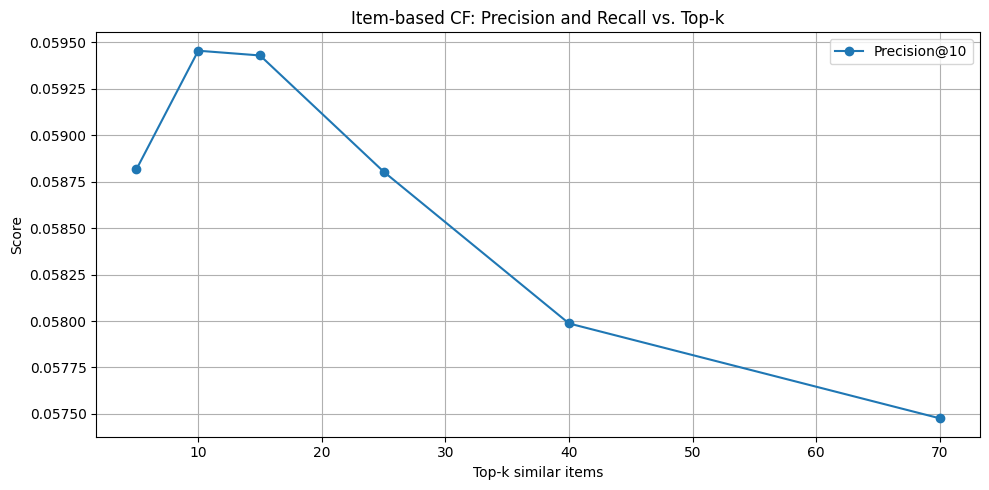

In [ ]:
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm

def top_k_filtering(similarity, k):
    filtered_sim = np.zeros_like(similarity)
    for i in range(similarity.shape[0]):
        top_k_idx = np.argpartition(-similarity[i], kth=k+1)[:k+1]
        filtered_sim[i, top_k_idx] = similarity[i, top_k_idx]
    return filtered_sim

def item_based_predict(interactions, similarity, k=None, epsilon=1e-9):
    if k is not None:
        similarity = top_k_filtering(similarity, k)
    sim_sum = similarity.sum(axis=1, keepdims=True) + epsilon
    pred = interactions.dot(similarity.T) / sim_sum.T
    return pred

def evaluate_k(k, train_data_matrix, test_data_matrix, item_similarity, precision_recall_at_k_func, top_k):
    preds = item_based_predict(train_data_matrix, item_similarity, k=k)
    precision, recall = precision_recall_at_k_func(preds, test_data_matrix, k=top_k)
    print(f"k={k}: Precision@{top_k}={precision:.4f}, Recall@{top_k}={recall:.4f}")
    return precision, recall

def evaluate_item_based_predict_parallel(train_data_matrix, test_data_matrix, item_similarity, k_values, precision_recall_at_k_func, top_k=10, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_k)(k, train_data_matrix, test_data_matrix, item_similarity, precision_recall_at_k_func, top_k)
        for k in tqdm(k_values, desc="Grid search over k")
    )
    precisions, recalls = zip(*results)
    return list(precisions), list(recalls)

# Example usage
k_values = [5, 10, 15, 25, 40, 70]
precisions, recalls = evaluate_item_based_predict_parallel(
    train_data_matrix,
    test_data_matrix,
    item_similarity,
    k_values,
    precision_recall_at_k,
    top_k=10,
    n_jobs=4  
)

plt.figure(figsize=(10, 5))
plt.plot(k_values, precisions, marker='o', label='Precision@10')
plt.xlabel('Top-k similar items')
plt.ylabel('Score')
plt.title('Item-based CF: Precision and Recall vs. Top-k')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def top_k_filtering(similarity, k):
    filtered_sim = np.zeros_like(similarity)
    for i in tqdm(range(similarity.shape[0]), desc="Top-k Filtering"):
        top_k_idx = np.argpartition(-similarity[i], kth=k+1)[:k+1]
        filtered_sim[i, top_k_idx] = similarity[i, top_k_idx]
    return filtered_sim

def item_based_predict(interactions, similarity, k=None, epsilon=1e-9):
    if k is not None:
        similarity = top_k_filtering(similarity, k)
    sim_sum = similarity.sum(axis=1, keepdims=True) + epsilon
    pred = interactions.dot(similarity.T) / sim_sum.T
    return pred

k = 12
item_prediction_k10 = item_based_predict(train_data_matrix, item_similarity, k=k)

precision_item_k, recall_item_k = precision_recall_at_k(item_prediction_k10, test_data_matrix, k=10)
print('Item-based CF Precision@K:', precision_item_k)
print('Item-based CF Recall@K:', recall_item_k)

Top-k Filtering: 100%|██████████| 15291/15291 [00:01<00:00, 12134.74it/s]


Item-based CF Precision@K: 0.0595687675427436
Item-based CF Recall@K: 0.2841622472940364


#### Item to item (3 folds)

Folds: 100%|██████████| 3/3 [04:45<00:00, 95.08s/it]


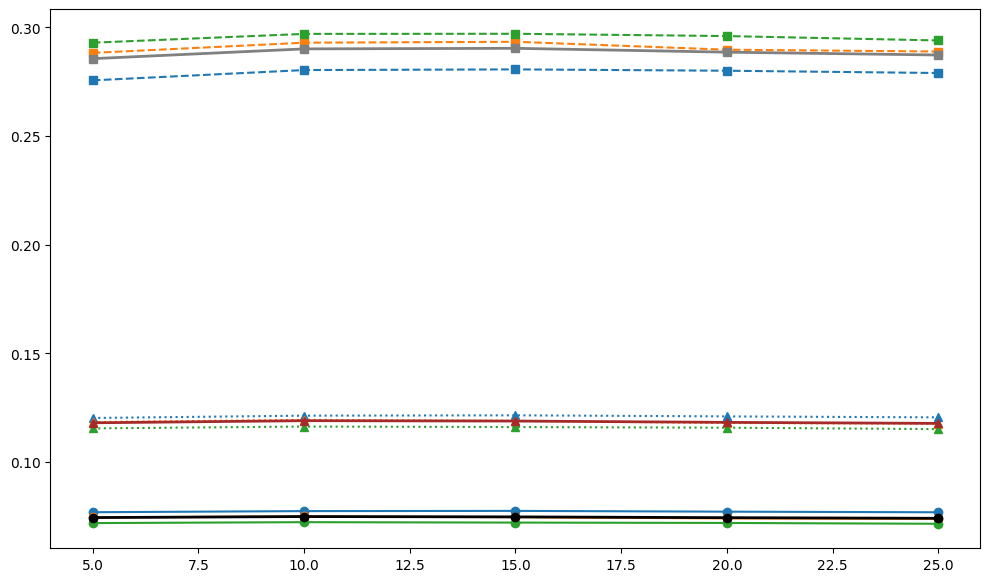

In [ ]:
train_test_pairs = [
    (train_1, test_1),
    (train_2, test_2),
    (train_3, test_3)
]

k_values = [5, 10, 15, 20, 25]
num_folds = 3

# Store metrics for each fold and k
precision_folds = np.zeros((num_folds, len(k_values)))
recall_folds = np.zeros((num_folds, len(k_values)))
f1_folds = np.zeros((num_folds, len(k_values)))

for fold_idx, (train_df, test_df) in enumerate(tqdm(train_test_pairs, desc="Folds")):
    train_matrix = create_data_matrix(train_df, n_users, n_items)
    test_matrix = create_data_matrix(test_df, n_users, n_items)
    similarity = cosine_similarity(train_matrix.T)
    for k_idx, k in enumerate(k_values):
        predictions = item_based_predict(train_matrix, similarity, k=k)
        precision, recall = precision_recall_at_k(predictions, test_matrix, k=10)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        precision_folds[fold_idx, k_idx] = precision
        recall_folds[fold_idx, k_idx] = recall
        f1_folds[fold_idx, k_idx] = f1

# Plot
plt.figure(figsize=(12, 7))
colors = plt.cm.tab10.colors

for fold_idx in range(num_folds):
    plt.plot(k_values, precision_folds[fold_idx], marker='o', color=colors[fold_idx], label=f'Precision Fold {fold_idx+1}', linestyle='-')
    plt.plot(k_values, recall_folds[fold_idx], marker='s', color=colors[fold_idx], label=f'Recall Fold {fold_idx+1}', linestyle='--')
    plt.plot(k_values, f1_folds[fold_idx], marker='^', color=colors[fold_idx], label=f'F1 Fold {fold_idx+1}', linestyle=':')

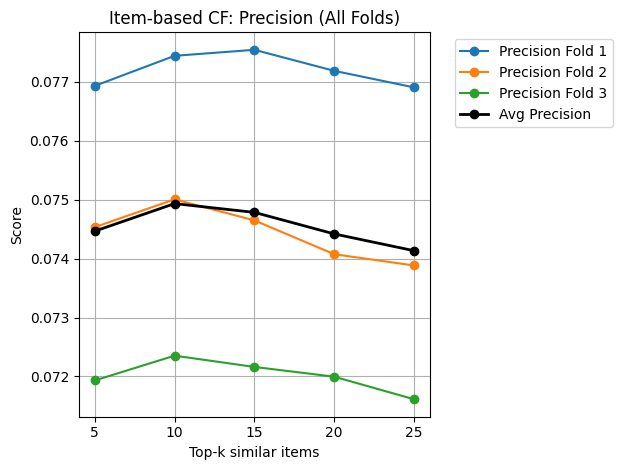

In [ ]:
for fold_idx in range(3):
    plt.plot(k_values, precision_folds[fold_idx], marker='o', color=colors[fold_idx], label=f'Precision Fold {fold_idx+1}', linestyle='-')

# Plot average lines
plt.plot(k_values, precision_folds.mean(axis=0), marker='o', color='black', label='Avg Precision', linewidth=2)

plt.xlabel('Top-k similar items')
plt.ylabel('Score')
plt.title('Item-based CF: Precision (All Folds)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### User to user

#### u2u basic

In [27]:
similarity_matrix = cosine_similarity(train_data_matrix)

def user_based_predict(interactions, similarity, epsilon=1e-9):
    """
    Compute predictions using user-user similarities
    
    Parameters:
    - interactions: user-item interaction matrix (users x items)
    - similarity: user-user similarity matrix (users x users) 
    - epsilon: small value to avoid division by zero
    
    Returns:
    - predictions: matrix of predicted ratings (users x items)
    """
    sim_sum = np.abs(similarity).sum(axis=1)[:, np.newaxis] + epsilon
    pred = similarity.dot(interactions) / sim_sum
    return pred

# Compute predictions using user-based similarities
u2u_basic = user_based_predict(train_data_matrix, similarity_matrix)

# Evaluate
precision, recall = precision_recall_at_k(u2u_basic, test_data_matrix, k=10)

print(f"Precision@10: {precision:.4f}")
print(f"Recall@10:    {recall:.4f}")

Precision@10: 0.0565
Recall@10:    0.2907


#### User to user tuning

Grid search over k: 100%|██████████| 5/5 [00:00<00:00, 3170.30it/s]


k=16: Precision@10=0.0567, Recall@10=0.2852k=20: Precision@10=0.0567, Recall@10=0.2865k=18: Precision@10=0.0566, Recall@10=0.2857


k=22: Precision@10=0.0568, Recall@10=0.2870
k=24: Precision@10=0.0565, Recall@10=0.2869


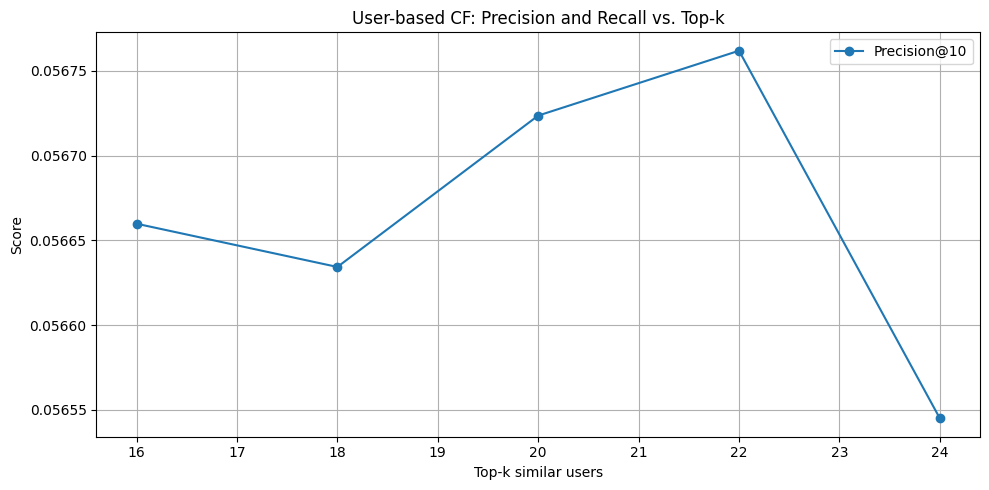

In [ ]:
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Compute user-user similarity matrix
user_similarity = cosine_similarity(train_data_matrix)

def user_based_predict(interactions, similarity, epsilon=1e-9):
    sim_sum = np.abs(similarity).sum(axis=1)[:, np.newaxis] + epsilon
    pred = similarity.dot(interactions) / sim_sum
    return pred

def top_k_similarities(similarity, k):
    new_sim = np.zeros_like(similarity)
    for i in range(similarity.shape[0]):
        top_k_idx = np.argsort(similarity[i])[-k:]
        new_sim[i, top_k_idx] = similarity[i, top_k_idx]
    return new_sim

def evaluate_user_k(k, train_data_matrix, test_data_matrix, user_similarity, precision_recall_at_k_func, top_k):
    user_similarity_top_k = top_k_similarities(user_similarity, k)
    preds = user_based_predict(train_data_matrix, user_similarity_top_k)
    precision, recall = precision_recall_at_k_func(preds, test_data_matrix, k=top_k)
    print(f"k={k}: Precision@{top_k}={precision:.4f}, Recall@{top_k}={recall:.4f}")
    return precision, recall

def evaluate_user_based_predict_parallel(train_data_matrix, test_data_matrix, user_similarity, k_values, precision_recall_at_k_func, top_k=10, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_user_k)(k, train_data_matrix, test_data_matrix, user_similarity, precision_recall_at_k_func, top_k)
        for k in tqdm(k_values, desc="Grid search over k")
    )
    precisions, recalls = zip(*results)
    return list(precisions), list(recalls)

# Example usage
k_values = [16, 18, 20, 22, 24]
precisions, recalls = evaluate_user_based_predict_parallel(
    train_data_matrix,
    test_data_matrix,
    user_similarity,
    k_values,
    precision_recall_at_k,
    top_k=10,
    n_jobs=4  # adjust as needed
)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(k_values, precisions, marker='o', label='Precision@10')
plt.xlabel('Top-k similar users')
plt.ylabel('Score')
plt.title('User-based CF: Precision and Recall vs. Top-k')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

def user_based_predict(interactions, similarity, epsilon=1e-9):
    pred = similarity.dot(interactions) / (np.abs(similarity).sum(axis=1)[:, np.newaxis] + epsilon)
    return pred

def top_k_similarities(similarity, k):
    new_sim = np.zeros_like(similarity)
    for i in range(similarity.shape[0]):
        top_k_idx = np.argsort(similarity[i])[-k:]
        new_sim[i, top_k_idx] = similarity[i, top_k_idx]
    return new_sim

# Choose your specific k
chosen_k = 23

# Compute top-k similarity and prediction for this k
user_similarity_top_k = top_k_similarities(user_similarity, chosen_k)
user_prediction_knn = user_based_predict(train_data_matrix, user_similarity_top_k)

# Evaluate
precision_user_k, recall_user_k = precision_recall_at_k(user_prediction_knn, test_data_matrix, k=10)
print(f"User-based CF (k={chosen_k}) Precision@10: {precision_user_k:.4f}")
print(f"User-based CF (k={chosen_k}) Recall@10: {recall_user_k:.4f}")

User-based CF (k=23) Precision@10: 0.0566
User-based CF (k=23) Recall@10: 0.2868


#### i2i combined with u2u

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm

# Define the weight range (from 0.38 to 0.42 exclusive, with 0.01 step)
weights = np.arange(0, 1, 0.05)

# Function to evaluate a single weight
def evaluate_weight(weight):
    weighted_prediction = (weight * i2i_basic) + ((1 - weight) * u2u_basic)
    precision, recall = precision_recall_at_k(weighted_prediction, test_data_matrix, k=10)
    return precision, recall

# Run the job in parallel
results = Parallel(n_jobs=6)(
    delayed(evaluate_weight)(weight) for weight in tqdm(weights, desc="Tuning weight")
)

# Unzip the results
precision_scores, recall_scores = zip(*results)

# Optional: Convert to numpy arrays
precision_scores = np.array(precision_scores)
recall_scores = np.array(recall_scores)


Tuning weight: 100%|██████████| 20/20 [00:32<00:00,  1.63s/it]


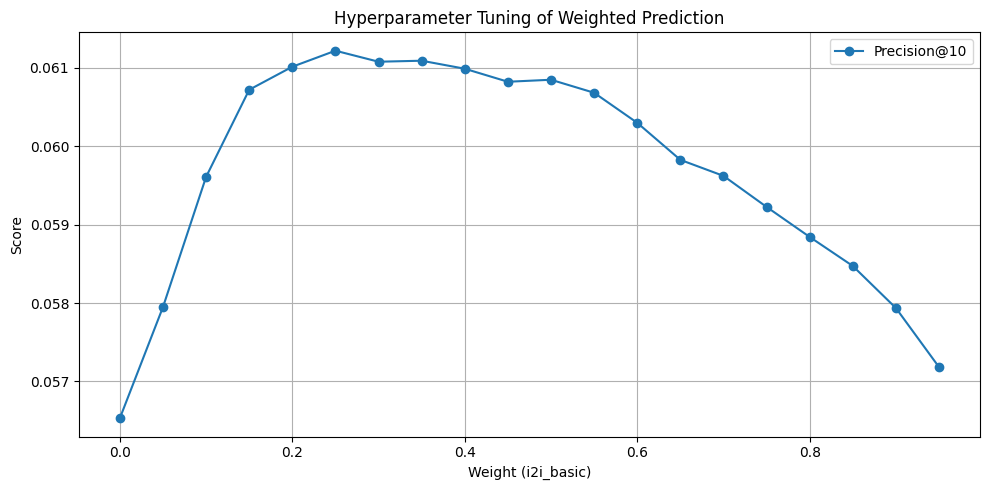

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(weights, precision_scores, label='Precision@10', marker='o')
plt.xlabel('Weight (i2i_basic)')
plt.ylabel('Score')
plt.title('Hyperparameter Tuning of Weighted Prediction')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Final i2i & u2u hybrid

In [ ]:
weight = 0.22

i2i_u2u_array = (weight * i2i_basic) + ((1 - weight) * u2u_basic)
precision, recall = precision_recall_at_k(i2i_u2u_array, test_data_matrix, k=10)

print(precision)
print(recall)

0.06124011227354252
0.2953293127440811


## Content-based filtering

#### Evaluation TFIDF

In [66]:
# Evaluation
def precision_recall_at_k(recommendations, test_df, k):
    user_test_items = test_df.groupby('u')['i'].apply(set).to_dict()
    precisions, recalls = [], []

    for user, recs in recommendations.items():
        if user not in user_test_items:
            continue
        actual = user_test_items[user]
        hits = len(set(recs[:k]) & actual)

        precisions.append(hits / k)
        recalls.append(hits / len(actual) if actual else 0)

    return np.mean(precisions), np.mean(recalls)

#### TFIDF similarity matrix

In [64]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

# Enable tqdm for pandas
tqdm.pandas()

# Load French stopwords
french_stopwords = set(stopwords.words('french'))

# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    tokens = text.split()
    tokens = [word for word in tokens if word not in french_stopwords]
    return ' '.join(tokens)

# Build books dataframe
def build_books_content_df(items_df):
    books = pd.DataFrame()
    books['i'] = items_df['i'] 
    books['content'] = items_df[['Title', 'Author',  'Publisher', 'Subjects']].fillna('').agg(' '.join, axis=1)
    books['content_clean'] = books['content'].progress_apply(preprocess_text)
    
    return books

# Compute TF-IDF and similarity
def compute_tfidf_similarity(text_series):
    vectorizer = TfidfVectorizer(
        stop_words=None,        # We've already applied stopword removal
        ngram_range=(1, 2),
        max_df=0.4,
        min_df=1
    )
    tfidf_matrix = vectorizer.fit_transform(text_series)

    # Manual cosine similarity with progress
    cosine_sim = np.zeros((tfidf_matrix.shape[0], tfidf_matrix.shape[0]))

    for i in tqdm(range(tfidf_matrix.shape[0]), desc="Computing similarity"):
        cosine_sim[i] = cosine_similarity(tfidf_matrix[i], tfidf_matrix).flatten()

    return cosine_sim

books = build_books_content_df(items)

cosine_sim = compute_tfidf_similarity(books['content_clean'])

Computing similarity: 100%|██████████| 15291/15291 [00:52<00:00, 292.51it/s]


##### TFIDF mean

In [67]:
def content_based_recommender(books, train_data, cosine_sim, top_k=10):
    i_to_idx = {i: idx for idx, i in enumerate(books['i'])}
    idx_to_i = {idx: i for i, idx in i_to_idx.items()}

    user_train_items = train_data.groupby('u')['i'].apply(set).to_dict()
    user_recommendations = {}

    us = list(user_train_items.keys())
    item_ids = [idx_to_i[i] for i in range(len(idx_to_i))]
    user_scores_matrix_df = pd.DataFrame(index=us, columns=item_ids, dtype=np.float32)

    for user in tqdm(us, desc="Generating recommendations"):
        interacted_books = user_train_items[user]
        interacted_indices = [i_to_idx[b] for b in interacted_books if b in i_to_idx]
        if not interacted_indices:
            continue

        sim_scores = np.mean(cosine_sim[interacted_indices], axis=0)
        user_scores_matrix_df.loc[user] = sim_scores.astype(np.float32)

        top_indices = np.argsort(sim_scores)[::-1]
        recommended_books = [idx_to_i[i] for i in top_indices]
        user_recommendations[user] = recommended_books[:top_k]

    return user_recommendations, user_scores_matrix_df

user_recommendations_TFIDF, user_scores_matrix_TFIDF_df = content_based_recommender(
    books=books,
    train_data=train_data,
    cosine_sim=cosine_sim,
    top_k=10
)

precision, recall = precision_recall_at_k(
    recommendations=user_recommendations_TFIDF,
    test_df=test_data,
    k=10
)

print(f"Precision@10: {precision:.4f}")
print(f"Recall@10: {recall:.4f}")


TFIDF_mean_array = user_scores_matrix_TFIDF_df.to_numpy()

Generating recommendations: 100%|██████████| 7838/7838 [00:14<00:00, 523.72it/s]


Precision@10: 0.0579
Recall@10: 0.2979


### OpenAI

In [33]:
def precision_recall_at_k(prediction, ground_truth, k=10):
    """
    Calculates Precision@K and Recall@K for top-K recommendations.
    Parameters:
        prediction (numpy array): The predicted interaction matrix with scores.
        ground_truth (numpy array): The ground truth interaction matrix (binary).
        k (int): Number of top recommendations to consider.
    Returns:
        precision_at_k (float): The average precision@K over all users.
        recall_at_k (float): The average recall@K over all users.
    """
    num_users = prediction.shape[0]
    precision_at_k, recall_at_k = 0, 0

    for user in range(num_users):
        # TODO: Get the indices of the top-K items for the user based on predicted scores
        top_k_items = np.argsort(prediction[user, :])[-k:]

        # TODO: Calculate the number of relevant items in the top-K items for the user
        relevant_items_in_top_k = np.isin(top_k_items, np.where(ground_truth[user, :] == 1)[0]).sum()

        # TODO: Calculate the total number of relevant items for the user
        total_relevant_items = ground_truth[user, :].sum()

        # Precision@K and Recall@K for this user
        precision_at_k += relevant_items_in_top_k / k
        recall_at_k += relevant_items_in_top_k / total_relevant_items if total_relevant_items > 0 else 0

    # Average Precision@K and Recall@K over all users
    precision_at_k /= num_users
    recall_at_k /= num_users

    return precision_at_k, recall_at_k


In [34]:
train_matrix = train_data_matrix.copy()
test_matrix = test_data_matrix.copy()

us = interactions["u"].unique()
item_ids = items["i"].unique()
u_map = {u: idx for idx, u in enumerate(us)}
item_id_map = {i: idx for idx, i in enumerate(item_ids)}
rev_u_map = {v: k for k, v in u_map.items()}

n_users = len(u_map)
n_items = len(item_id_map)

# Create index map for embedding rows
embedding_index_map = dict(zip(items["i"], range(len(items))))

n_users = interactions.u.nunique()
n_items = items.i.nunique() # CHECK
embedding_dim = book_embeddings_openai.shape[1]
user_embeddings = np.zeros((n_users, embedding_dim), dtype=np.float32)

for u_idx in range(n_users):
    item_indices = np.where(train_matrix[u_idx] > 0)[0]
    valid_embedding_indices = []

    for item_idx in item_indices:
        # Get original item ID
        orig_i = list(item_id_map.keys())[list(item_id_map.values()).index(item_idx)]
        if orig_i in embedding_index_map:
            valid_embedding_indices.append(embedding_index_map[orig_i])

    if valid_embedding_indices:
        vectors = book_embeddings_openai[valid_embedding_indices]
        user_embeddings[u_idx] = vectors.mean(axis=0)


content_scores = cosine_similarity(user_embeddings, book_embeddings_openai)


embed_aligned = np.zeros((n_users, n_items), dtype=np.float32)

for orig_i, idx in item_id_map.items():
    if orig_i in embedding_index_map:
        embed_aligned[:, idx] = content_scores[:, embedding_index_map[orig_i]]

precision, recall = precision_recall_at_k(embed_aligned, test_matrix, k=10)
print(f"✅ OpenAI Embeddings → Precision@10: {precision:.4f} | Recall@10: {recall:.4f}")


✅ OpenAI Embeddings → Precision@10: 0.0437 | Recall@10: 0.2603


In [35]:
# Normalize embed_aligned between 0 and 1
embed_aligned_norm = (embed_aligned - embed_aligned.min()) / (embed_aligned.max() - embed_aligned.min())

## Hybrid models

In [55]:
from itertools import product
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm

user_to_user = u2u_basic
item_to_item = i2i_basic
tfidf = TFIDF_mean_array
embeddings = embed_aligned_norm

# Grids (adjust as needed)
user_grid = np.arange(0.25, 0.35, 0.025)
item_grid = np.arange(0.15, 0.25, 0.025)
tfidf_grid = np.arange(0.15, 0.25, 0.025)   # Corrected direction
embed_grid = np.arange(0.25, 0.35, 0.025)

# Stack matrices to allow vectorized combination
score_components = np.stack([user_to_user, item_to_item, tfidf, embeddings])

# Generate combinations that sum (approximately) to 1
combinations = [
    (w_user_user, w_item_item, w_tfidf, w_embed)
    for w_user_user, w_item_item, w_tfidf, w_embed in product(user_grid, item_grid, tfidf_grid, embed_grid)
    if abs((w_user_user + w_item_item + w_tfidf + w_embed) - 1.0) < 0.0001
]

print(f"Total combinations to evaluate: {len(combinations)}")


def precision_recall_at_k(prediction, ground_truth, k=10):
    """Vectorized Precision@K and Recall@K computation."""
    num_users = prediction.shape[0]
    precision_total, recall_total = 0.0, 0.0

    for user_idx in range(num_users):
        scores = prediction[user_idx]
        top_k = np.argpartition(scores, -k)[-k:]
        top_k = top_k[np.argsort(scores[top_k])]  # Optional: sort top-K

        relevant_items = np.where(ground_truth[user_idx] == 1)[0]
        if relevant_items.size == 0:
            continue

        hits = np.intersect1d(top_k, relevant_items).size
        precision_total += hits / k
        recall_total += hits / len(relevant_items)

    return precision_total / num_users, recall_total / num_users


def evaluate_combination(weights):
    """Compute weighted hybrid score and evaluate precision/recall."""
    weights = np.array(weights)
    weights /= weights.sum()  # Normalize just in case
    hybrid_scores = np.tensordot(weights, score_components, axes=1)
    precision, recall = precision_recall_at_k(hybrid_scores, test_matrix, k=10)
    return precision, recall, tuple(weights)


# Parallel grid search with progress bar
results = Parallel(n_jobs=4)(
    delayed(evaluate_combination)(combo) for combo in tqdm(combinations, desc="Evaluating weights")
)

# Select best by Precision@10
best_result = max(results, key=lambda x: x[0])
best_precision, best_recall, best_weights = best_result

print(f"\nBest Weights → user_user: {best_weights[0]:.3f}, item_item: {best_weights[1]:.3f}, "
      f"tfidf: {best_weights[2]:.3f}, embed: {best_weights[3]:.3f}")
print(f"Best P@10: {best_precision:.4f}, R@10: {best_recall:.4f}")

Total combinations to evaluate: 31


Evaluating weights: 100%|██████████| 31/31 [02:29<00:00,  4.81s/it]



Best Weights → user_user: 0.300, item_item: 0.200, tfidf: 0.200, embed: 0.300
Best P@10: 0.0650, R@10: 0.3256


In [68]:
import numpy as np

# Manual weights (must sum to 1.0)
w_user_user = 0.28
w_item_item = 0.24
w_tfidf = 0.22
w_embed = 0.26

# Sanity check
assert abs(w_user_user + w_item_item + w_tfidf + w_embed - 1.0) < 1e-6, "Weights must sum to 1.0"

# Evaluation function
def precision_recall_at_k(prediction, ground_truth, k=10):
    num_users = prediction.shape[0]
    precision_at_k, recall_at_k = 0, 0
    for user in range(num_users):
        top_k_items = np.argsort(prediction[user])[-k:]
        relevant_items = np.where(ground_truth[user] == 1)[0]
        relevant_items_in_top_k = np.intersect1d(top_k_items, relevant_items).size
        total_relevant = len(relevant_items)
        precision_at_k += relevant_items_in_top_k / k
        recall_at_k += relevant_items_in_top_k / total_relevant if total_relevant > 0 else 0
    return precision_at_k / num_users, recall_at_k / num_users

# Compute hybrid score
hybrid_scores = (
    w_user_user * u2u_basic +
    w_item_item * i2i_basic +
    w_tfidf * TFIDF_mean_array +
    w_embed * embed_aligned
)

# Evaluate
precision, recall = precision_recall_at_k(hybrid_scores, test_matrix, k=10)

# Print results
print(f"Manual Weights → user_user: {w_user_user}, item_item: {w_item_item}, tfidf: {w_tfidf}, embed: {w_embed}")
print(f"P@10: {precision:.4f}, R@10: {recall:.4f}")


Manual Weights → user_user: 0.28, item_item: 0.24, tfidf: 0.22, embed: 0.26
P@10: 0.0650, R@10: 0.3252
